In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import math
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.utils import resample
warnings.simplefilter(action='ignore', category=FutureWarning)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.11/site

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.11/site

AttributeError: _ARRAY_API not found

# Data Cleaning

In [2]:
df = pd.read_csv('data/rideshare_kaggle.csv')

# select variables needed for this project
selected_vars = [
    "id", "price", "distance", "cab_type", "name",
    "timestamp", "hour", "day", "source", "destination",
    "temperature", "precipIntensity", "precipProbability", "cloudCover",
    "surge_multiplier", "short_summary"
]

df = df[selected_vars].copy()
df.head()

,id,price,distance,cab_type,name,timestamp,hour,day,source,destination,temperature,precipIntensity,precipProbability,cloudCover,surge_multiplier,short_summary
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,5.0,0.44,Lyft,Shared,1.544953e+09,9,16,Haymarket Square,North Station,42.34,0.0000,0.0,0.72,1.0,Mostly Cloudy
1,4bd23055-6827-41c6-b23b-3c491f24e74d,11.0,0.44,Lyft,Lux,1.543284e+09,2,27,Haymarket Square,North Station,43.58,0.1299,1.0,1.00,1.0,Rain
2,981a3613-77af-4620-a42a-0c0866077d1e,7.0,0.44,Lyft,Lyft,1.543367e+09,1,28,Haymarket Square,North Station,38.33,0.0000,0.0,0.03,1.0,Clear
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,26.0,0.44,Lyft,Lux Black XL,1.543554e+09,4,30,Haymarket Square,North Station,34.38,0.0000,0.0,0.00,1.0,Clear
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,9.0,0.44,Lyft,Lyft XL,1.543463e+09,3,29,Haymarket Square,North Station,37.44,0.0000,0.0,0.44,1.0,Partly Cloudy


In [3]:
# rename the original day to day_of_month
df['day_of_month'] = df['day'].astype(int)

# fix timestamp and create proper day variables
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

df["month_name"] = df["datetime"].dt.month_name()  # January, February, ...
df["day_of_week"] = df["datetime"].dt.day_name()  # Monday, Tuesday, ...


# create a new binary indicator for is_weekend
df['is_weekend'] = df['day_of_week'].isin(["Saturday", "Sunday"])

# remove variables not needed
df = df.drop(columns=["day", "timestamp", "datetime"])

df.head()

,id,price,distance,cab_type,name,hour,source,destination,temperature,precipIntensity,precipProbability,cloudCover,surge_multiplier,short_summary,day_of_month,month_name,day_of_week,is_weekend
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,5.0,0.44,Lyft,Shared,9,Haymarket Square,North Station,42.34,0.0000,0.0,0.72,1.0,Mostly Cloudy,16,December,Sunday,True
1,4bd23055-6827-41c6-b23b-3c491f24e74d,11.0,0.44,Lyft,Lux,2,Haymarket Square,North Station,43.58,0.1299,1.0,1.00,1.0,Rain,27,November,Tuesday,False
2,981a3613-77af-4620-a42a-0c0866077d1e,7.0,0.44,Lyft,Lyft,1,Haymarket Square,North Station,38.33,0.0000,0.0,0.03,1.0,Clear,28,November,Wednesday,False
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,26.0,0.44,Lyft,Lux Black XL,4,Haymarket Square,North Station,34.38,0.0000,0.0,0.00,1.0,Clear,30,November,Friday,False
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,9.0,0.44,Lyft,Lyft XL,3,Haymarket Square,North Station,37.44,0.0000,0.0,0.44,1.0,Partly Cloudy,29,November,Thursday,False


In [4]:
# General info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 693071 non-null  object 
 1   price              637976 non-null  float64
 2   distance           693071 non-null  float64
 3   cab_type           693071 non-null  object 
 4   name               693071 non-null  object 
 5   hour               693071 non-null  int64  
 6   source             693071 non-null  object 
 7   destination        693071 non-null  object 
 8   temperature        693071 non-null  float64
 9   precipIntensity    693071 non-null  float64
 10  precipProbability  693071 non-null  float64
 11  cloudCover         693071 non-null  float64
 12  surge_multiplier   693071 non-null  float64
 13  short_summary      693071 non-null  object 
 14  day_of_month       693071 non-null  int64  
 15  month_name         693071 non-null  object 
 16  da

In [5]:
# Shape
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 693071, Columns: 18


In [6]:
# Check for duplicates
print(f"Duplicated rows: {df.duplicated().sum()}")

Duplicated rows: 0


In [7]:
# number of missing values
df.isna().sum().sort_values(ascending=False).head()

price           55095
id                  0
day_of_week         0
month_name          0
day_of_month        0
dtype: int64

### Outcome Variable Check

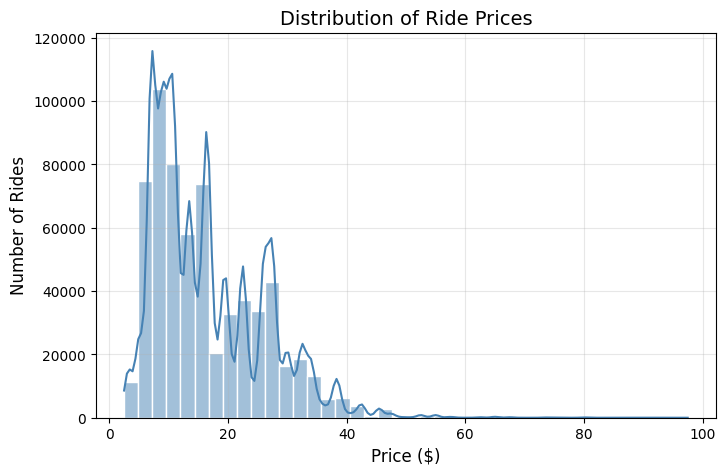

In [8]:
# distribution of price (original), with na values removed
prices = df['price'].dropna()

plt.figure(figsize=(8,5))
sns.histplot(prices, bins=40, kde=True, color='steelblue', edgecolor='white')

plt.title('Distribution of Ride Prices', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

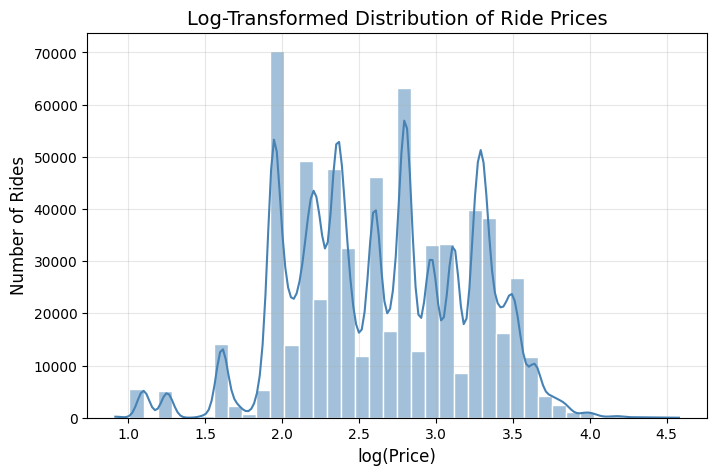

In [9]:
# distribution of price (transformed), with na values removed
# Use np.log1p() to handle any zero or near-zero prices safely
prices = np.log(df['price'].dropna())

plt.figure(figsize=(8,5))
sns.histplot(prices, bins=40, kde=True, color='steelblue', edgecolor='white')

plt.title('Log-Transformed Distribution of Ride Prices', fontsize=14)
plt.xlabel('log(Price)', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

### Categorical Variables Check

In [10]:
categorical_var = [
    "cab_type",
    "name",
    "source",
    "destination",
    "short_summary",
    "month_name",
    "day_of_week",
    "is_weekend"
]

In [11]:
cat_summary = df[categorical_var].describe()

print("\n===== Categorical Variables Summary =====")
display(cat_summary)


===== Categorical Variables Summary =====


,cab_type,name,source,destination,short_summary,month_name,day_of_week,is_weekend
count,693071,693071,693071,693071,693071,693071,693071,693071
unique,2,13,12,12,9,2,7,2
top,Uber,UberXL,Financial District,Financial District,Overcast,December,Tuesday,False
freq,385663,55096,58857,58851,218895,406614,124949,511373


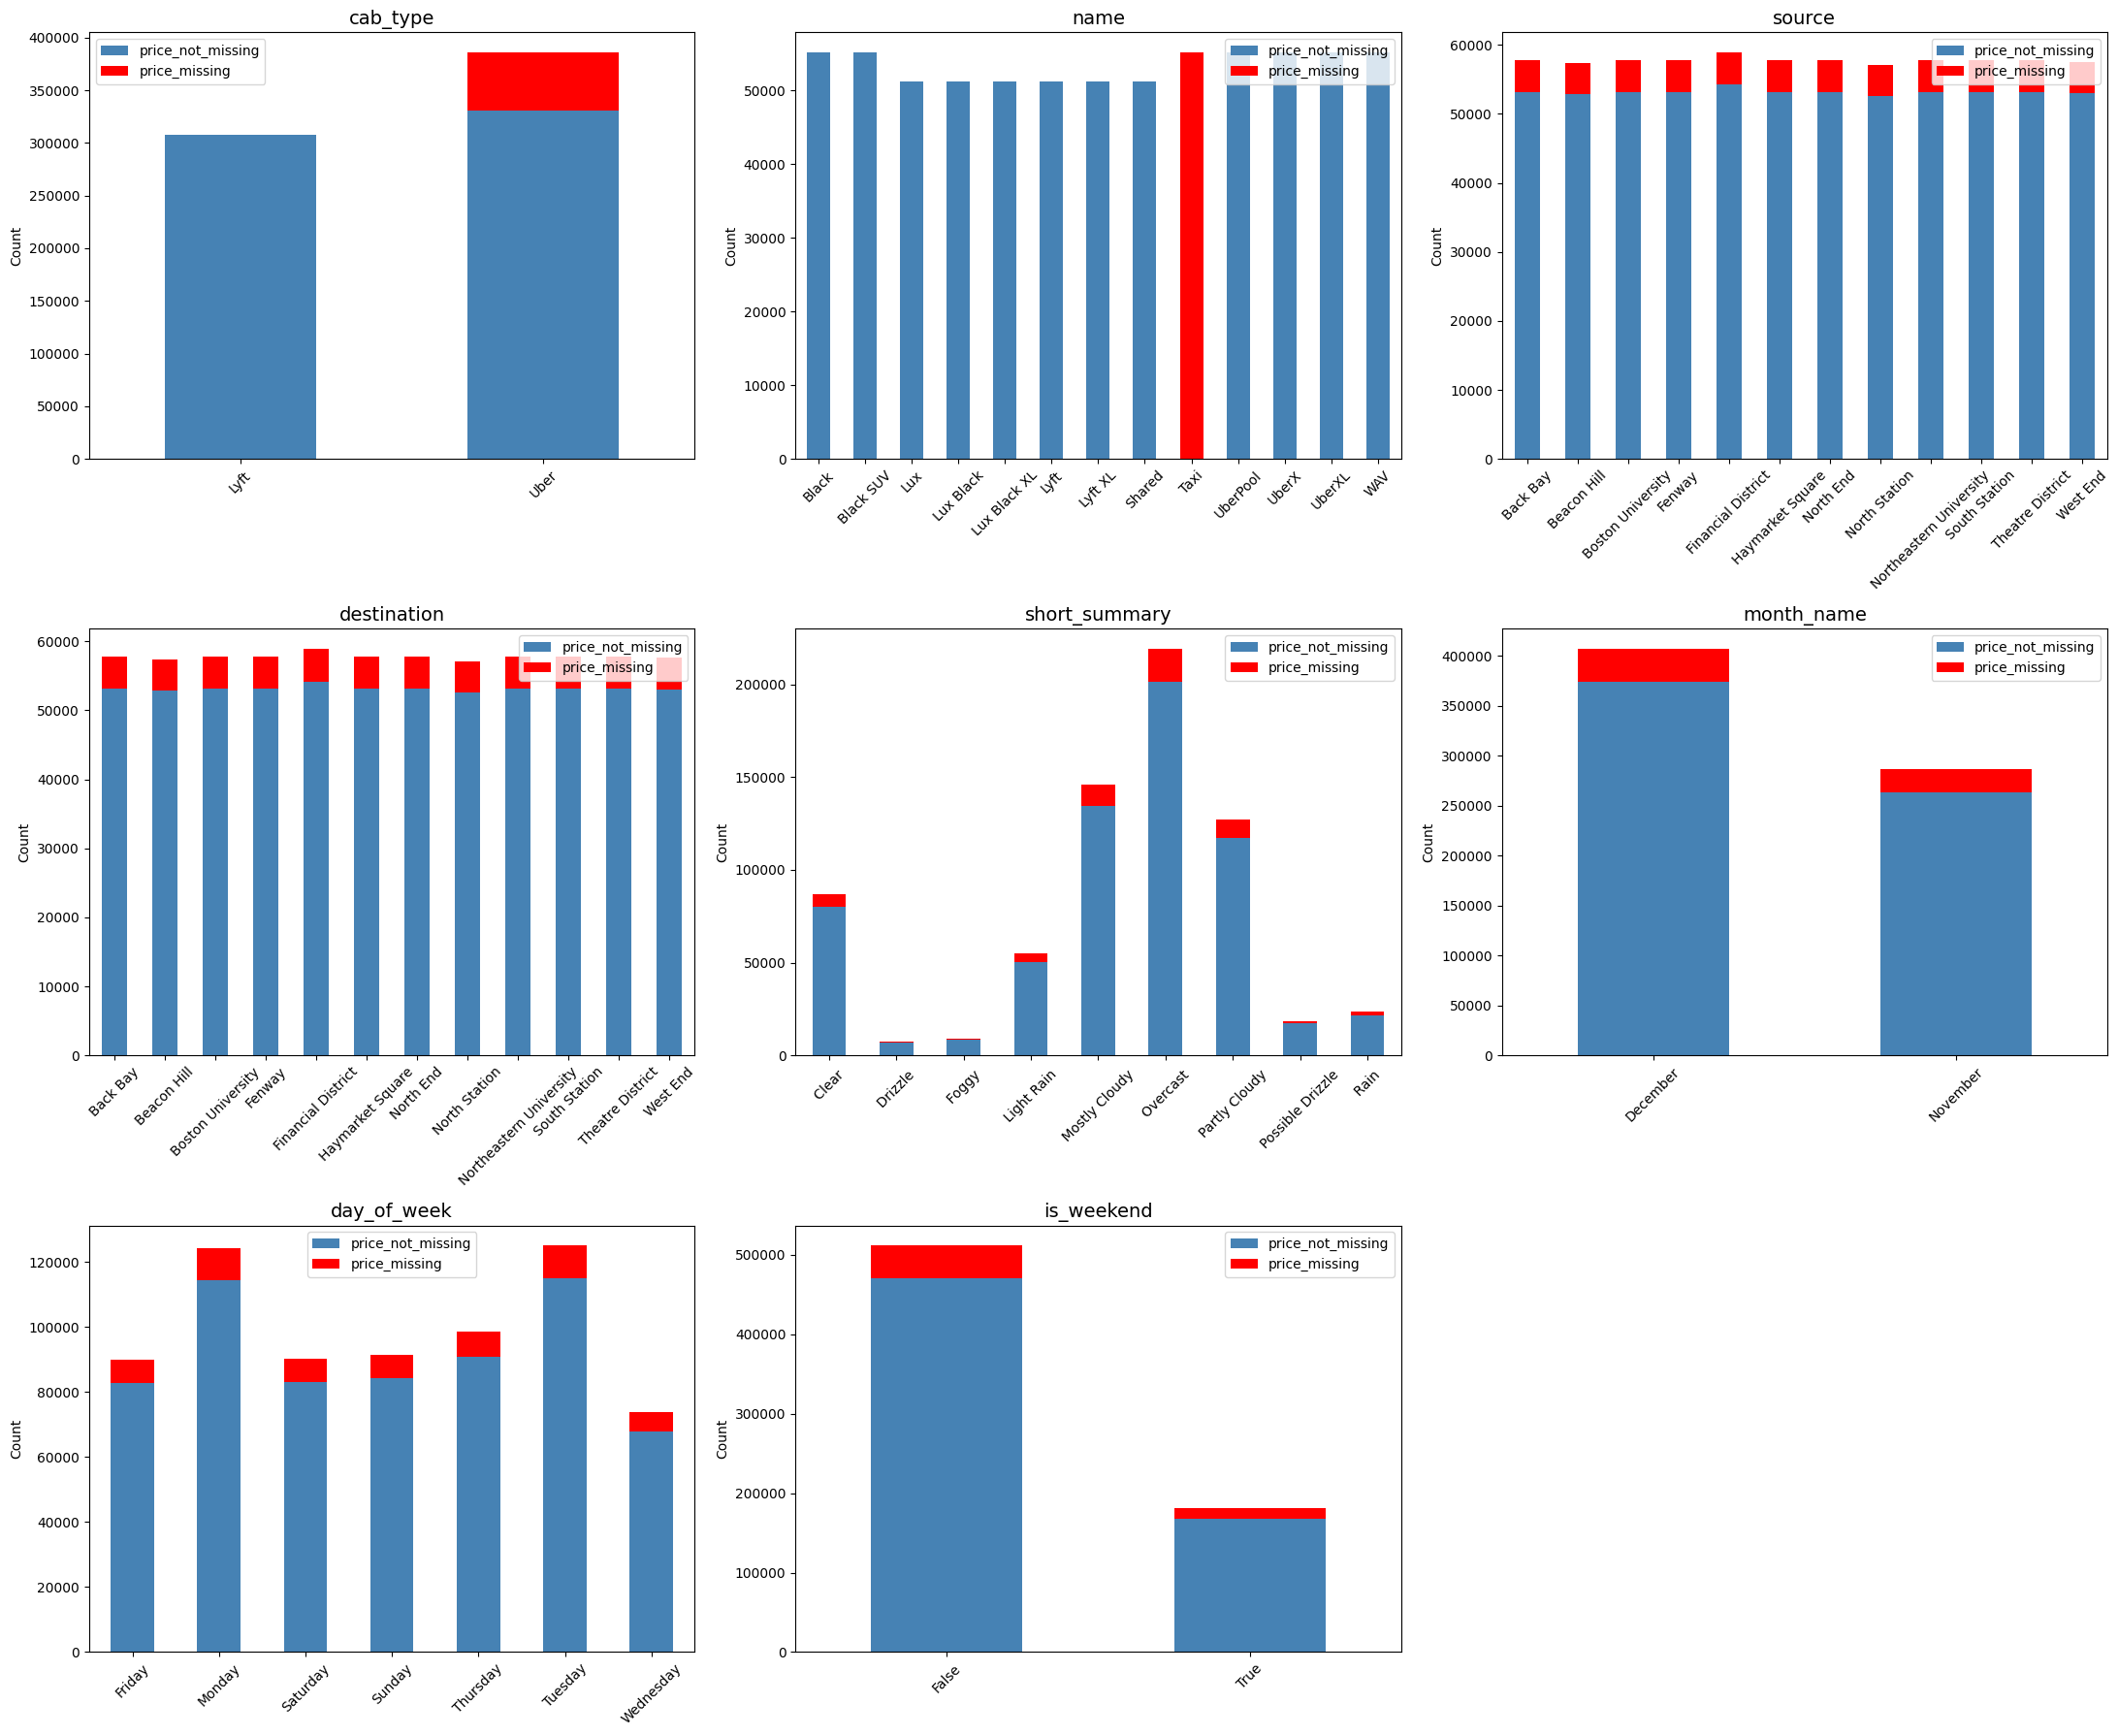

In [12]:
n = len(categorical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(22, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(categorical_var):
    # group category by price missing / not missing
    counts = df.groupby([col, df['price'].isna()]).size().unstack(fill_value=0)
    # rename columns for clarity
    counts.columns = ['price_not_missing', 'price_missing']
    
    # stacked bar plot
    counts[['price_not_missing', 'price_missing']].plot(
        kind='bar',
        stacked=True,
        ax=axes[i],
        color=['steelblue', 'red']  # normal + missing price in red
    )
    
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', labelrotation=45)

# hide unused subplots if number of vars % 3 != 0
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

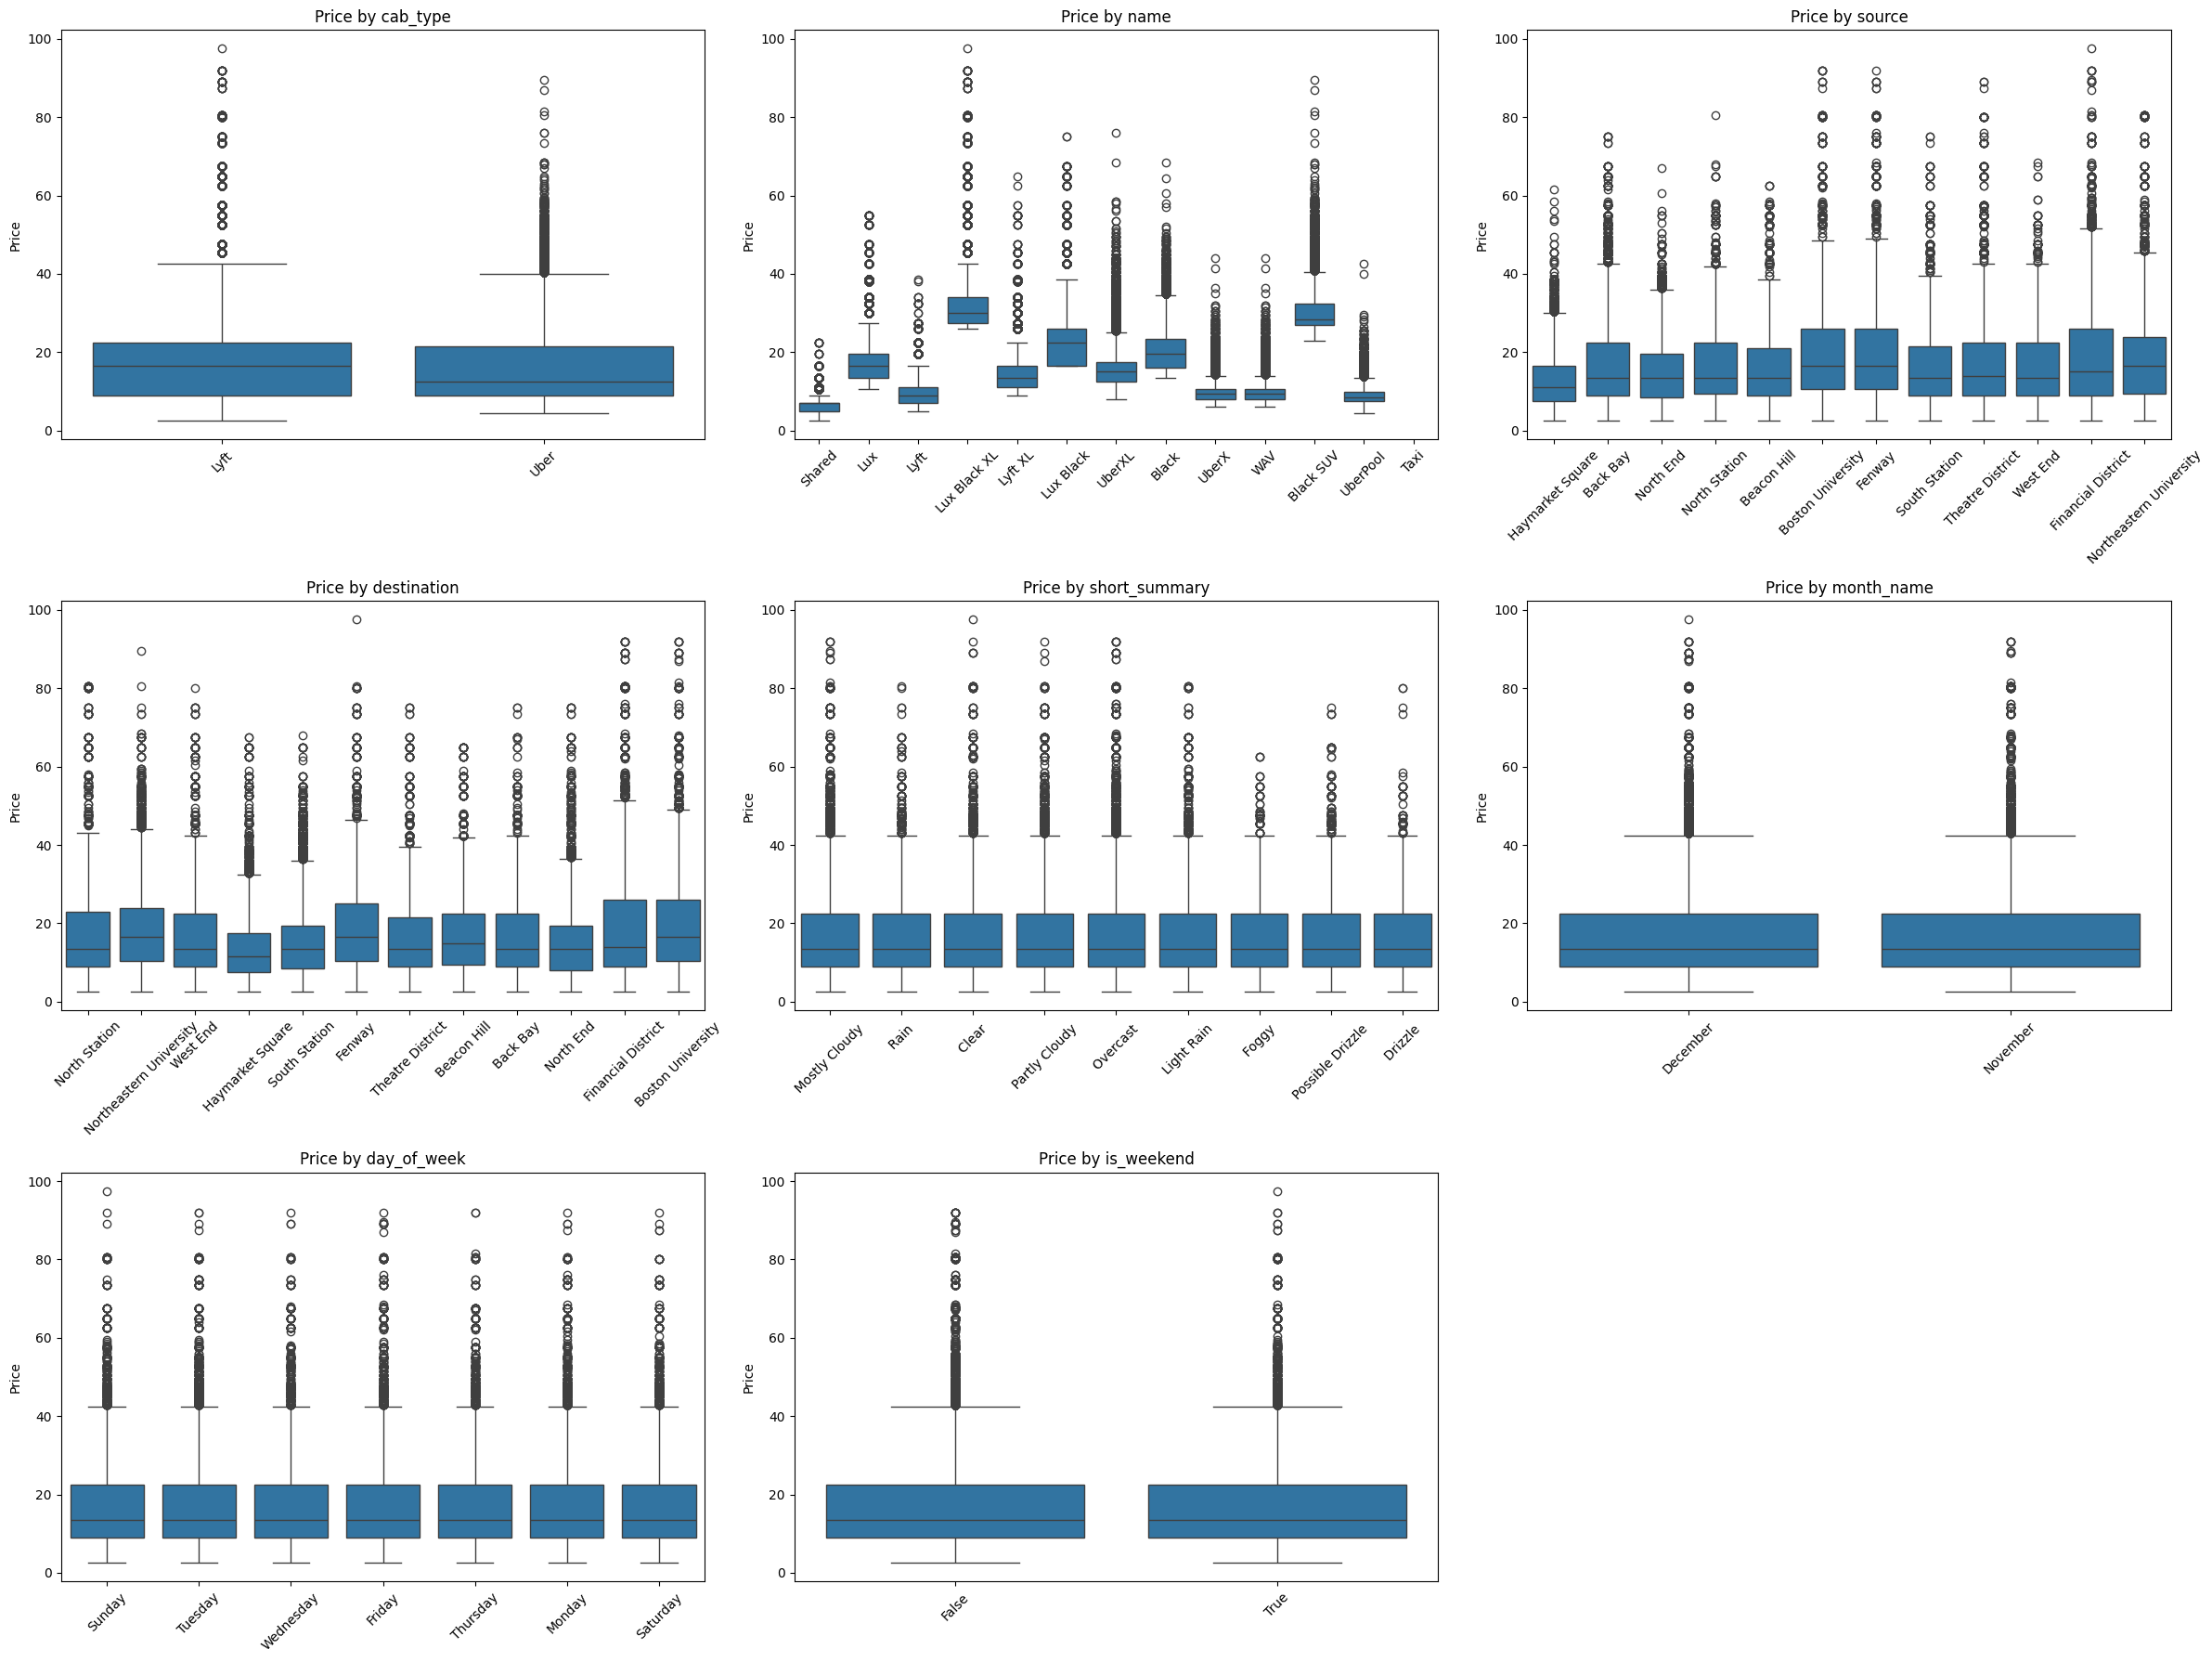

In [13]:
n = len(categorical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(24, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(categorical_var):
    sns.boxplot(data=df, x=col, y="price", ax=axes[i])
    axes[i].set_title(f"Price by {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Price")
    axes[i].tick_params(axis="x", rotation=45)

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Across categorical predictors, price exhibits relatively consistent patterns with a few meaningful differences. Cab type and service name show the strongest price variation, with premium services (e.g., Lyft Lux, Lyft XL) generally yielding higher fares compared to standard offerings. Pickup and drop-off locations also influence pricing, with certain hubs (e.g., airports and major transport stations) associated with higher median fares, likely reflecting longer distances and greater demand. In contrast, weather-related categories (short_summary), day of week, weekend indicator, and month show only modest differences in price distributions, suggesting they play a secondary role relative to service level and location. Overall, the categorical EDA indicates that ride type and geographic endpoints are key drivers of price, while temporal and weather-based variables may have weaker direct effects.

### Numerical Variables Check

In [14]:
numerical_var = [
    "distance",
    "hour",
    "temperature",
    "precipIntensity",
    "precipProbability",
    "cloudCover",
    "surge_multiplier",
    "day_of_month"
]

In [15]:
num_summary = df[numerical_var].describe().round(2)

print("\n===== Numerical Variables Summary =====")
display(num_summary)


===== Numerical Variables Summary =====


,distance,hour,temperature,precipIntensity,precipProbability,cloudCover,surge_multiplier,day_of_month
count,693071.00,693071.00,693071.00,693071.00,693071.00,693071.00,693071.00,693071.00
mean,2.19,11.62,39.58,0.01,0.15,0.69,1.01,17.79
std,1.14,6.95,6.73,0.03,0.33,0.36,0.09,9.98
min,0.02,0.00,18.91,0.00,0.00,0.00,1.00,1.00
25%,1.28,6.00,36.45,0.00,0.00,0.37,1.00,13.00
50%,2.16,12.00,40.49,0.00,0.00,0.82,1.00,17.00
75%,2.92,18.00,43.58,0.00,0.00,1.00,1.00,28.00
max,7.86,23.00,57.22,0.14,1.00,1.00,3.00,30.00


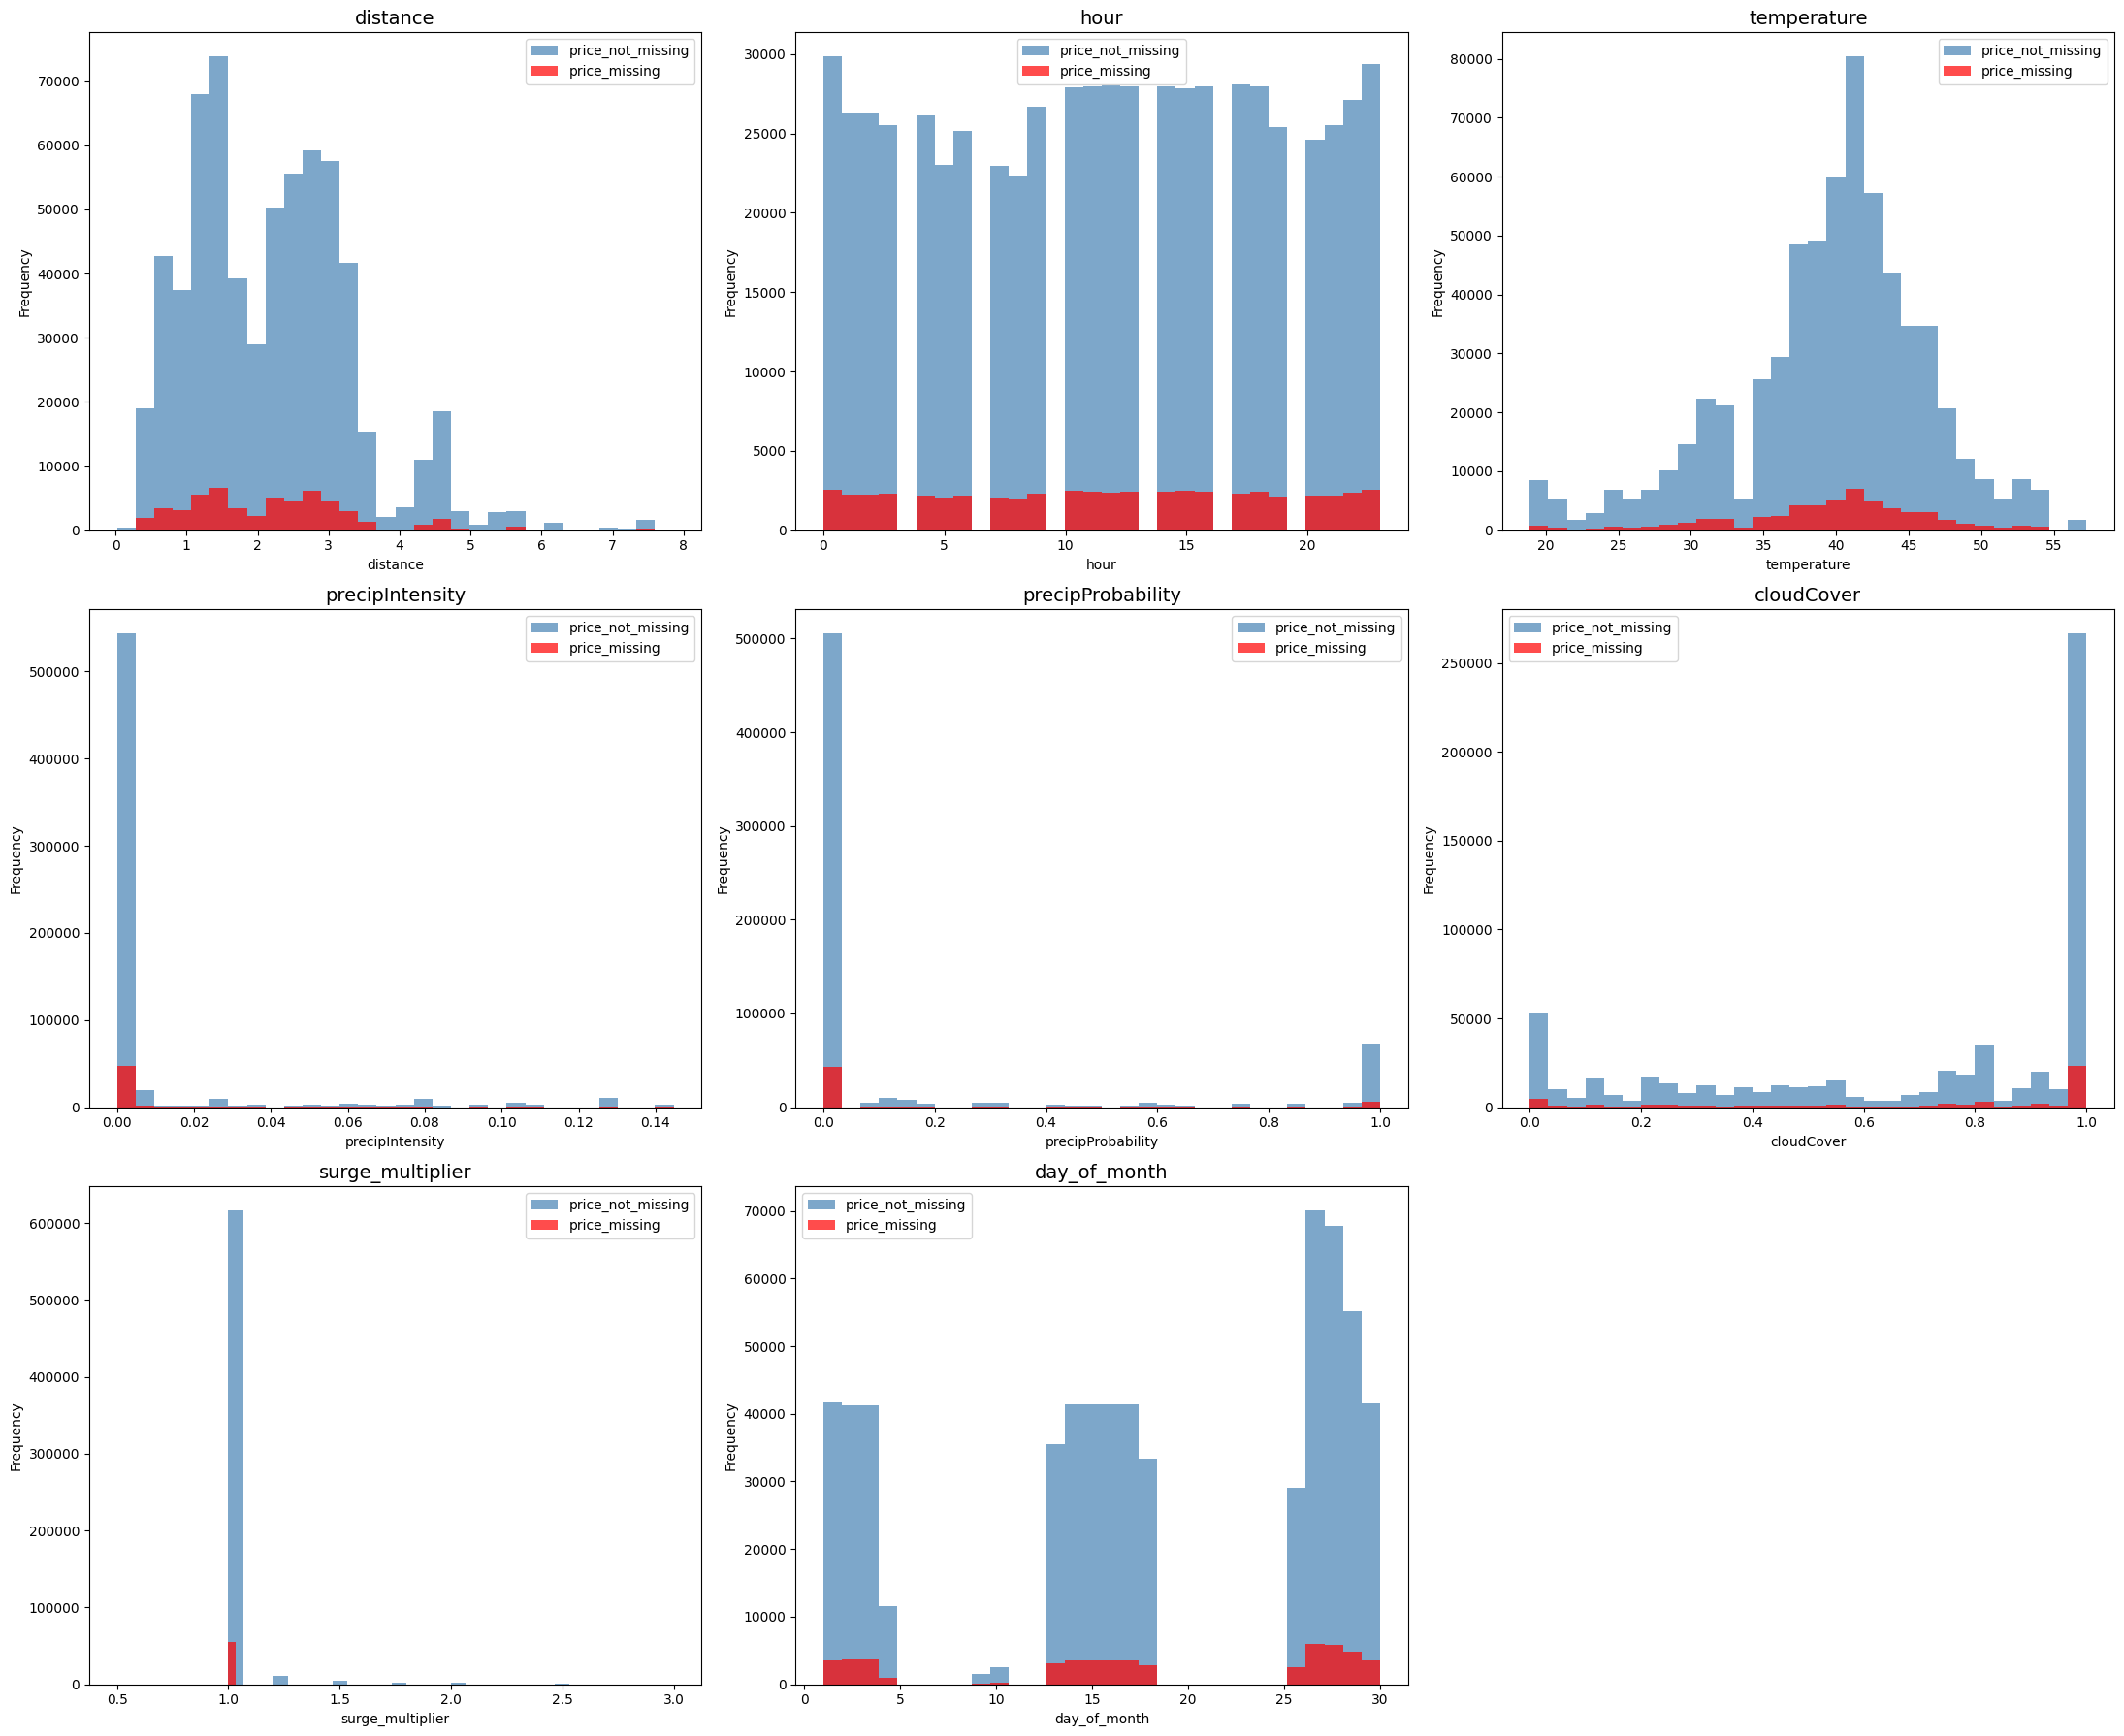

In [16]:
n = len(numerical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(22, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_var):
    # valid price values
    df[df["price"].notna()][col].plot(
        kind='hist',
        bins=30,
        alpha=0.7,
        color='steelblue',
        ax=axes[i],
        label="price_not_missing"
    )

    # missing price values
    df[df["price"].isna()][col].plot(
        kind='hist',
        bins=30,
        alpha=0.7,
        color='red',
        ax=axes[i],
        label="price_missing"
    )

    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

# hide unused subplots (if number of vars not divisible by 3)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

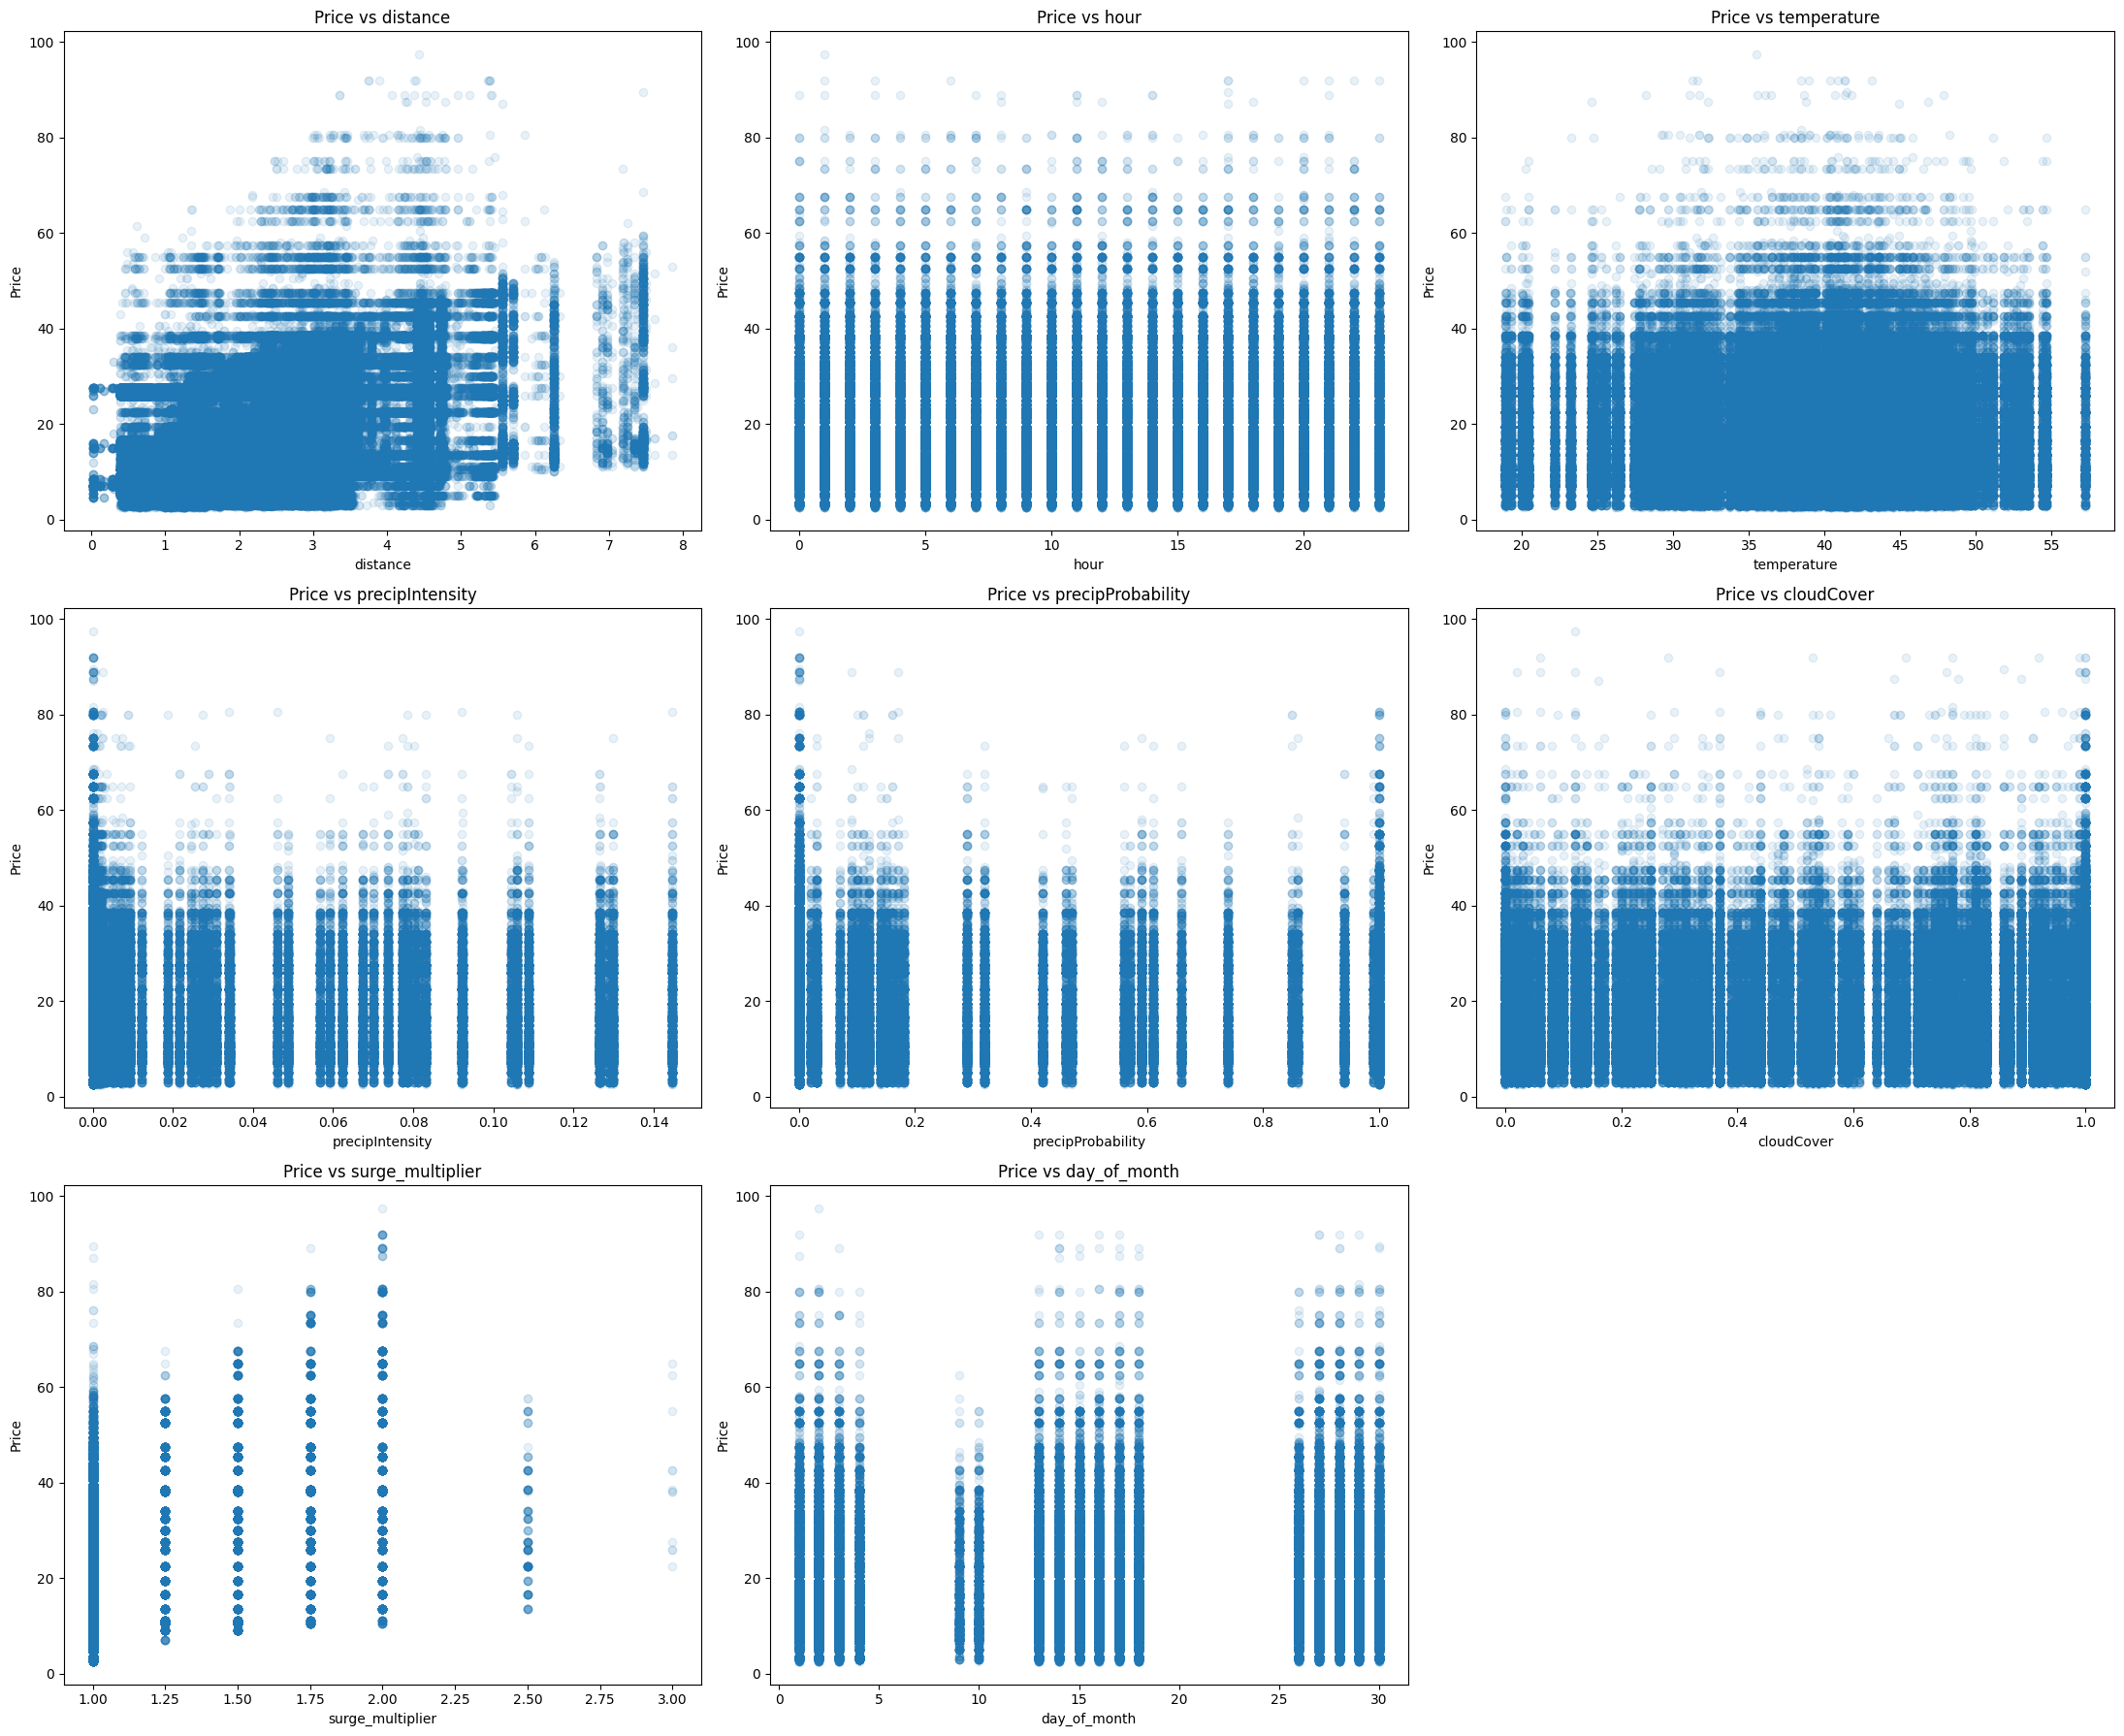

In [17]:
n = len(numerical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(22, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_var):
    axes[i].scatter(df[col], df["price"], alpha=0.1)
    axes[i].set_title(f"Price vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Price")

# hide unused subplots if not multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [18]:
# Outlier detection
outlier_summary = {}

for col in numerical_var:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = outliers

pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])

,Outlier Count
distance,8662
hour,0
temperature,36659
precipIntensity,150828
precipProbability,150828
cloudCover,0
surge_multiplier,20975
day_of_month,0


In [19]:
# Scalling
scaler = StandardScaler()
scaled = scaler.fit_transform(df[numerical_var])

scaled_df = pd.DataFrame(scaled, columns=[c + '_scaled' for c in numerical_var])
scaled_df.head()

,distance_scaled,hour_scaled,temperature_scaled,precipIntensity_scaled,precipProbability_scaled,cloudCover_scaled,surge_multiplier_scaled,day_of_month_scaled
0,-1.536021,-0.376957,0.409691,-0.331672,-0.444083,0.093430,-0.151349,-0.179755
1,-1.536021,-1.384425,0.594048,4.497229,2.596003,0.874388,-0.151349,0.922198
2,-1.536021,-1.528349,-0.186496,-0.331672,-0.444083,-1.831073,-0.151349,1.022375
3,-1.536021,-1.096577,-0.773763,-0.331672,-0.444083,-1.914747,-0.151349,1.222730
4,-1.536021,-1.240501,-0.318817,-0.331672,-0.444083,-0.687527,-0.151349,1.122553


Findings: The numerical predictors in our dataset exhibit a wide range of distributional behaviors. 

- Distance shows a multimodal distribution reflecting different ride types (short local trips vs. longer airport rides). 
- Hour is uniformly distributed. 
- Temperature is moderately distributed. 
- Weather variables, especially precipIntensity and precipProbability, are extremely right-skewed, with over 150,000 outliers each, reflecting the rarity of heavy precipitation events. CloudCover is left-skewed.
- Surge_multiplier is highly concentrated at 1.0, indicating that the vast majority of rides occur without surge pricing.
- Day_of_month has three peaks, suggesting limited temporal coverage in the dataset.

All predictors were standardized.

### Covariance check

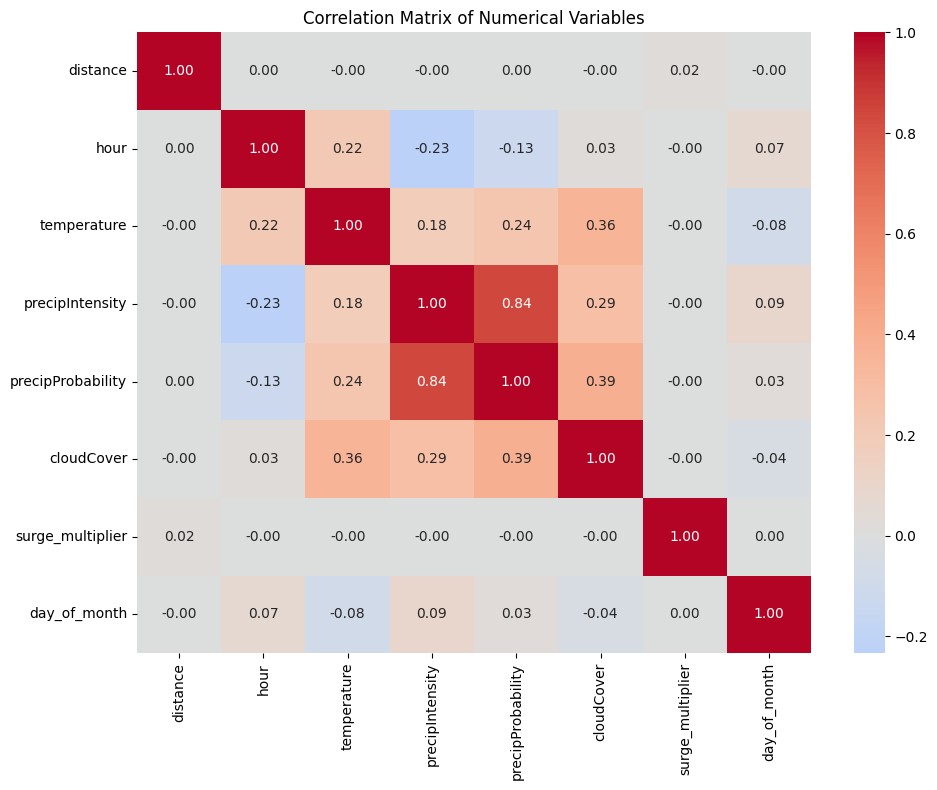

Correlation Matrix:
                   distance      hour  temperature  precipIntensity  \
distance           1.000000  0.002280    -0.002884        -0.000256   
hour               0.002280  1.000000     0.218769        -0.233349   
temperature       -0.002884  0.218769     1.000000         0.182724   
precipIntensity   -0.000256 -0.233349     0.182724         1.000000   
precipProbability  0.000371 -0.129725     0.239165         0.838470   
cloudCover        -0.000905  0.026525     0.355156         0.288960   
surge_multiplier   0.024769 -0.000077    -0.001572        -0.001530   
day_of_month      -0.000627  0.066090    -0.084116         0.091664   

                   precipProbability  cloudCover  surge_multiplier  \
distance                    0.000371   -0.000905          0.024769   
hour                       -0.129725    0.026525         -0.000077   
temperature                 0.239165    0.355156         -0.001572   
precipIntensity             0.838470    0.288960         -0.

In [20]:
corr_matrix = df[numerical_var].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(corr_matrix)

Insights: `precipIntensity` and `precipProbability` are highly correlated (r = 0.84), suggesting potential multicollinearity issues.

Most variables show weak correlations with each other ($|r|$ < 0.4), indicating minimal multicollinearity concerns. Weather variables (temperature, cloudCover) show moderate intercorrelations (0.29-0.39) but are likely manageable in the model.

### Train-test split

In [21]:
# train-test-validation split

# remove missing values 
df_clean = df.dropna()

X = df_clean[['distance']].values
y = np.log(df_clean['price']) # log-transform price

# first split: 80% train+val, 20% test
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# second split: 75% of train+val for train (60% overall), 25% for val (20% overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_and_val, y_train_and_val, test_size=0.25, random_state=42
)

print(f"\nData split sizes:")
print(f"Train: {len(X_train)} ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(df_clean)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(df_clean)*100:.1f}%)")
print(f"Train+Val: {len(X_train_and_val)} ({len(X_train_and_val)/len(df_clean)*100:.1f}%)")



Data split sizes:
Train: 382785 (60.0%)
Validation: 127595 (20.0%)
Test: 127596 (20.0%)
Train+Val: 510380 (80.0%)


### Baseline model: log(price) ~ distance


Baseline Model: log(price) ~ distance
Coefficient (distance): 0.1685
Intercept: 2.2819

Train R-sq: 0.1135
Validation R-sq: 0.1169
Train RMSE: 0.5347
Validation RMSE: 0.5368


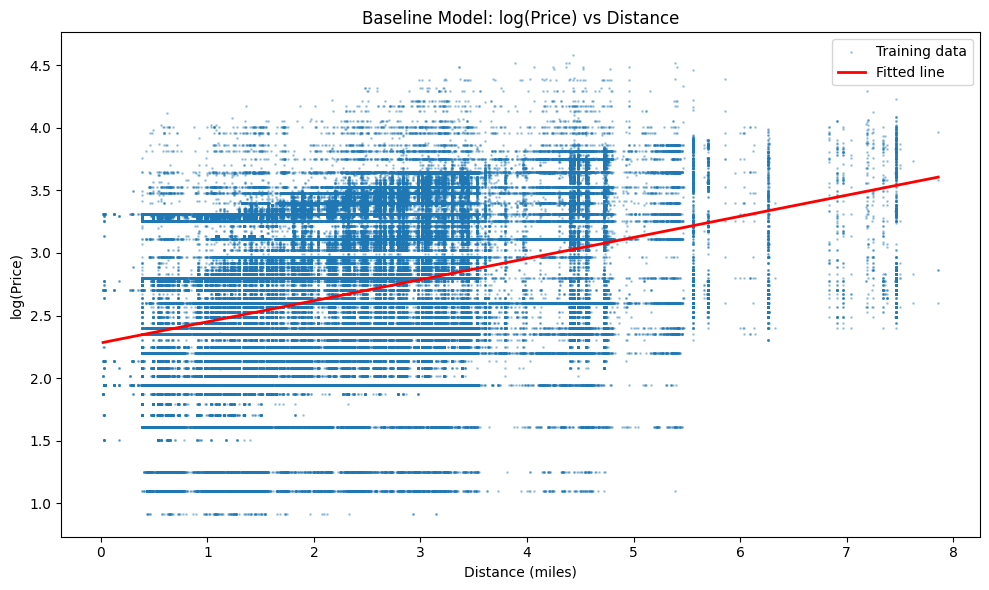

In [22]:
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("\nBaseline Model: log(price) ~ distance")
print(f"Coefficient (distance): {baseline_model.coef_[0]:.4f}")
print(f"Intercept: {baseline_model.intercept_:.4f}")
print(f"\nTrain R-sq: {train_r2:.4f}")
print(f"Validation R-sq: {val_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.3, label='Training data', s=1)

X_train_sorted = np.sort(X_train, axis=0)
plt.plot(X_train_sorted, 
         baseline_model.predict(X_train_sorted), 
         color='red', linewidth=2, label='Fitted line')

plt.xlabel('Distance (miles)')
plt.ylabel('log(Price)')
plt.title('Baseline Model: log(Price) vs Distance')
plt.legend()
plt.tight_layout()
plt.show()

The baseline model shows a positive linear relationship between distance and log-transformed price (coefficient = 0.169), but distance alone explains only about 11-12% of the variance in pricing (Train $R^2$ = 0.114, Validation $R^2$ = 0.117). The distinct horizontal banding in the scatter plot and low R² suggest that other factors—such as service type, surge pricing, and contextual variables—are necessary to adequately capture the ride-sharing pricing structure.